<a href="https://colab.research.google.com/github/NEEJUSINGH/google-ai-trendspotting/blob/neeju-branch/Google_Trends_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🎬 Google Trends Entertainment Pipeline — Data Fetch → EDA → Features

This notebook **does not require a pre-made CSV**. It will:
1) Accept a movie list (upload, paste, or use sample).  
2) Fetch **Google Trends** data with **pytrends** in **batches** (resumable + backoff).  
3) (Optional) Pull **interest by region** and **related queries** per title.  
4) Produce **EDA visuals** (momentum, rolling means/vol bands, correlation).  
5) Build a **model-ready feature table** (time-series, event, semantic).  

> Runs on pure Python + Matplotlib (no seaborn). All plots are single-axes as requested.

## 0) Setup

In [2]:
%pip install pytrends openpyxl

In [3]:
import os, sys, time, json, re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pytrends.request import TrendReq

# check if we're running in colab envrionment
try:
    from google.colab import files, drive
    IN_COLAB = True
except Exception:
    IN_COLAB = False

print("In Colab:", IN_COLAB)

In Colab: True


## 1) Config — fetch controls

In [4]:
TIMEFRAME = "today 5-y"
GEO = ""
GPROP = ""
CAT = 0
BATCH_SIZE = 5
PAUSE = 2.0
RETRIES = 3
SAVE_PREFIX = "trends_batch"
FINAL_FILE = "all_trends.csv"
INCLUDE_REGION = True
INCLUDE_RELATED = False

OUTPUT_DIR = "."
if IN_COLAB:
    drive.mount('/content/drive')  # uncomment to mount
    OUTPUT_DIR = "/content/drive/MyDrive/TrendsProject"
os.makedirs(OUTPUT_DIR, exist_ok=True)
print("Outputs ->", os.path.abspath(OUTPUT_DIR))

Mounted at /content/drive
Outputs -> /content/drive/MyDrive/TrendsProject


## 2) Provide a movie list

In [ ]:
UPLOAD_MODE = True
PASTED_TITLES = []
SAMPLE_TITLES = [
    "Smile","It","Shang-Chi and the Legend of the Ten Rings","Avengers: Endgame",
    "Frozen","Frozen II","Joker","Black Panther","The Batman","Top Gun: Maverick",
    "Minions","Puss in Boots: The Last Wish"
]

def load_movie_list():
    if IN_COLAB and UPLOAD_MODE:
        print("Upload a CSV/XLSX with a 'title' column")
        uploaded = files.upload()
        if uploaded:
            fname = list(uploaded.keys())[0]
            if fname.lower().endswith(".csv"):
                df = pd.read_csv(fname)
            elif fname.lower().endswith((".xlsx",".xls")):
                df = pd.read_excel(fname)
            else:
                raise ValueError("Unsupported file type. Use CSV or XLSX.")
            df.columns = {c:str(c).strip().lower() for c in df.columns}
            if 'movie_title' in df.columns and 'title' not in df.columns:
                df = df.rename(columns={'movie_title':'title'})
            if 'name' in df.columns and 'title' not in df.columns:
                df = df.rename(columns={'name':'title'})
            if 'title' not in df.columns:
                raise ValueError("Uploaded sheet must include a 'title' column.")
            return df[['title']].dropna().drop_duplicates().reset_index(drop=True)
    if PASTED_TITLES:
        return pd.DataFrame({'title': sorted(set([t for t in PASTED_TITLES if str(t).strip()]))})
    return pd.DataFrame({'title': sorted(set(SAMPLE_TITLES))})

movies_df = load_movie_list()
print("Loaded titles:", len(movies_df))
display(movies_df.head(10))
movies_df.to_csv(os.path.join(OUTPUT_DIR, "movies_clean.csv"), index=False)

Upload a CSV/XLSX with a 'title' column


## 3) Add Interest Column

In [ ]:
# ---Add Interest Column Using PyTrends ---
!pip install pytrends --quiet

from pytrends.request import TrendReq
import pandas as pd
import time, random

# Load your original CSV
df = pd.read_csv("Movie_List - Sheet1.csv")   # adjust filename if needed
keywords = df['Movies'].dropna().unique().tolist()

pytrends = TrendReq(hl='en-US', tz=360)
all_trends = pd.DataFrame()

for kw in keywords[:20]:  # limit first 20 to test (to avoid 429 errors)
    try:
        pytrends.build_payload([kw], timeframe='today 5-y', geo='')
        data = pytrends.interest_over_time()
        data = data.reset_index()[['date', kw]]
        data = data.rename(columns={kw: 'interest'})
        data['keyword'] = kw
        all_trends = pd.concat([all_trends, data])
        print(f"Fetched: {kw}")
        time.sleep(5 + random.uniform(0,3))
    except Exception as e:
        print(f"Error fetching {kw}: {e}")

# Merge 'interest' back to your original dataset (if needed)
all_trends.to_csv("data/all_trends_with_interest.csv", index=False)
print("Saved trends with interest column.")
all_trends.head()


##4) Split Dataset (80/20)

In [ ]:
# ---Split Dataset ---
from sklearn.model_selection import train_test_split

df = pd.read_csv("data/all_trends_with_interest.csv")

# Example label creation for demo purposes (replace with your actual label)
# Let's create a binary label: interest above median = 1 (Emerging), else 0 (Stable)
df['label'] = (df['interest'] > df['interest'].median()).astype(int)

X = df[['interest']]    # features
y = df['label']         # label

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Split completed:")
print(f"Train: {X_train.shape}, Test: {X_test.shape}")


## 5) Initialize Baseline Models

In [ ]:
# ---Initialize and Train Baseline Models ---
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42, eval_metric='mlogloss')
}

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    print(f"\n📊 {name} Results:")
    print(classification_report(y_test, preds))


## 6) Save Trained Models


In [ ]:
import joblib, os

os.makedirs("models", exist_ok=True)
joblib.dump(models["Random Forest"], "models/random_forest_baseline.pkl")
joblib.dump(models["Gradient Boosting"], "models/gb_baseline.pkl")
joblib.dump(models["XGBoost"], "models/xgb_baseline.pkl")

print("Saved all baseline models.")


## 7) Normalize titles → pytrends keywords

In [ ]:
import re
def normalize_title(t):
    t = str(t).strip()
    return re.sub(r"\s+", " ", t)

def to_keyword(t):
    t = normalize_title(t)
    if " " in t and not (t.startswith('"') and t.endswith('"')):
        return f'"{t}"'
    return t

movies_df['keyword'] = movies_df['title'].apply(to_keyword)
kw_list = movies_df['keyword'].tolist()
print("Example keywords:", kw_list[:10])

## 8) Fetch Google Trends in batches (resumable + backoff)

In [ ]:
# This function handles API request failures to manage rate limits and temporary network issues.
def with_backoff(fn, *args, retries=3, pause=2.0, **kwargs):
    """
    Executes a function with a retry mechanism.

    Args:
        fn (function): The function to execute.
        *args: Positional arguments for the function.
        retries (int): The number of times to retry on failure.
        pause (float): The initial pause time in seconds between retries.
        **kwargs: Keyword arguments for the function.

    Returns:
        The result of the function call.

    Raises:
        RuntimeError: If the function fails after all retries.
    """
    for i in range(retries):
        try:
            return fn(*args, **kwargs)
        except Exception as e:
            print(f"  Error: {e} | attempt {i+1}/{retries}")

            # Increase pause time with each retry (exponential backoff)
            time.sleep(pause * (i + 1))
    raise RuntimeError("Failed after retries. Increase PAUSE or reduce batch size.")


def fetch_batches(kw_list, batch_size, timeframe, geo, gprop, cat,
                  save_prefix, final_file, include_region, include_related,
                  output_dir):
    """
    Fetches Google Trends data for a list of keywords in batches.

    Args:
        kw_list (list): A list of keywords to fetch data for.
        batch_size (int): The number of keywords to fetch per API call (max 5).
        timeframe (str): The time period for the data (e.g., 'today 3-y').
        geo (str): The geographic region (e.g., 'US').
        gprop (str): The Google search property (e.g., 'images').
        cat (int): The search category.
        save_prefix (str): The prefix for saving individual batch files.
        final_file (str): The name of the final, combined CSV file.
        include_region (bool): Whether to fetch regional interest data.
        include_related (bool): Whether to fetch related queries data.
        output_dir (str): The directory to save all output files.

    Returns:
        A pandas DataFrame containing the combined "interest over time" data.

    Raises:
        ValueError: If no batches are fetched.
    """
    pytrends = TrendReq(hl='en-US', tz=360)
    all_wide = []

    # Create the output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Process keywords in batches
    for i in range(0, len(kw_list), batch_size):
        batch = kw_list[i:i+batch_size]
        # Create a unique tag for each batch file (e.g., "trends_batch_000")
        tag = f"{save_prefix}_{i//batch_size:03d}"
        csv_path = os.path.join(output_dir, f"{tag}.csv")

        # Check if the batch has already been fetched and saved
        if os.path.exists(csv_path):
            print(f"Skipping existing batch {tag} ({len(batch)} kws)")
            df_batch = pd.read_csv(csv_path, parse_dates=['date'])
            all_wide.append(df_batch)
            continue # Move to the next batch

        print(f"Fetching batch {tag} ({len(batch)} kws) ...")

        # build the payload for the API request
        pytrends.build_payload(batch, timeframe=timeframe, geo=geo, gprop=gprop, cat=cat)

        # fetch 'Interest over time' data with the backoff retry mechanism
        df = with_backoff(pytrends.interest_over_time, retries=RETRIES, pause=PAUSE)

        # clean up the dataframe by dropping the 'isPartial' column and resetting the index
        df = df.drop(columns=['isPartial'], errors='ignore').reset_index()
        wide = df.copy()

        # save the current batch's data
        wide.to_csv(csv_path, index=False)
        all_wide.append(wide)
        print(f"  Saved {csv_path} (shape {wide.shape})")
        time.sleep(PAUSE)

        # Optionally, fetch and save 'Related queries' data
        if include_related:
            try:
                rq = with_backoff(pytrends.related_queries, retries=RETRIES, pause=PAUSE)
                for kw, dct in rq.items():
                    for kind, tbl in (dct or {}).items():
                        if tbl is None or not len(tbl):
                            continue
                        # Create and save a file for each type of related query (e.g., 'top', 'rising')
                        path = os.path.join(output_dir, f"{tag}_related_{kw}_{kind}.csv")
                        tbl.to_csv(path, index=False)
                print("  Saved related queries for batch.")
            except Exception as e:
                print("  Related queries fetch failed:", e)

    # Handle the case where the keyword list is empty or fetching failed
    if not all_wide:
        raise ValueError("No batches fetched.")

    # Combine all the individual batch dataframes into one large dataframe
    trends_df = None
    for w in all_wide:
        # Merge dataframes on the 'date' column
        trends_df = w if trends_df is None else trends_df.merge(w, on='date', how='outer')

    # Remove any duplicate columns that might have been created during the merge
    trends_df = trends_df.loc[:, ~trends_df.columns.duplicated()]

    # Save the final, combined dataframe to a single CSV file
    final_path = os.path.join(output_dir, final_file)
    trends_df.to_csv(final_path, index=False)
    print(f"\n✅ Combined and saved as {final_path} (shape {trends_df.shape})")

    return trends_df

# Example of how the function is called with predefined variables
trends_wide = fetch_batches(
    kw_list, BATCH_SIZE, TIMEFRAME, GEO, GPROP, CAT,
    SAVE_PREFIX, FINAL_FILE, INCLUDE_REGION, INCLUDE_RELATED,
    OUTPUT_DIR
)

Fetching batch trends_batch_000 (5 kws) ...


/usr/local/lib/python3.12/dist-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


  Saved /content/drive/MyDrive/TrendsProject/trends_batch_000.csv (shape (261, 6))
Fetching batch trends_batch_001 (5 kws) ...


/usr/local/lib/python3.12/dist-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


  Saved /content/drive/MyDrive/TrendsProject/trends_batch_001.csv (shape (261, 6))
Fetching batch trends_batch_002 (5 kws) ...


/usr/local/lib/python3.12/dist-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


  Saved /content/drive/MyDrive/TrendsProject/trends_batch_002.csv (shape (261, 6))
Fetching batch trends_batch_003 (5 kws) ...


/usr/local/lib/python3.12/dist-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


  Saved /content/drive/MyDrive/TrendsProject/trends_batch_003.csv (shape (261, 6))
Fetching batch trends_batch_004 (5 kws) ...


/usr/local/lib/python3.12/dist-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


  Saved /content/drive/MyDrive/TrendsProject/trends_batch_004.csv (shape (261, 6))
Fetching batch trends_batch_005 (5 kws) ...


/usr/local/lib/python3.12/dist-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


  Saved /content/drive/MyDrive/TrendsProject/trends_batch_005.csv (shape (261, 6))
Fetching batch trends_batch_006 (5 kws) ...


/usr/local/lib/python3.12/dist-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


  Saved /content/drive/MyDrive/TrendsProject/trends_batch_006.csv (shape (261, 6))
Fetching batch trends_batch_007 (5 kws) ...


/usr/local/lib/python3.12/dist-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


  Saved /content/drive/MyDrive/TrendsProject/trends_batch_007.csv (shape (261, 6))
Fetching batch trends_batch_008 (5 kws) ...


/usr/local/lib/python3.12/dist-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


  Saved /content/drive/MyDrive/TrendsProject/trends_batch_008.csv (shape (261, 6))
Fetching batch trends_batch_009 (5 kws) ...


/usr/local/lib/python3.12/dist-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


  Saved /content/drive/MyDrive/TrendsProject/trends_batch_009.csv (shape (261, 6))
Fetching batch trends_batch_010 (5 kws) ...


/usr/local/lib/python3.12/dist-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


  Saved /content/drive/MyDrive/TrendsProject/trends_batch_010.csv (shape (261, 6))
Fetching batch trends_batch_011 (5 kws) ...


/usr/local/lib/python3.12/dist-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


  Saved /content/drive/MyDrive/TrendsProject/trends_batch_011.csv (shape (261, 6))
Fetching batch trends_batch_012 (5 kws) ...


/usr/local/lib/python3.12/dist-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


  Saved /content/drive/MyDrive/TrendsProject/trends_batch_012.csv (shape (261, 6))
Fetching batch trends_batch_013 (5 kws) ...


/usr/local/lib/python3.12/dist-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


  Saved /content/drive/MyDrive/TrendsProject/trends_batch_013.csv (shape (261, 6))
Fetching batch trends_batch_014 (5 kws) ...


/usr/local/lib/python3.12/dist-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


  Saved /content/drive/MyDrive/TrendsProject/trends_batch_014.csv (shape (261, 6))
Fetching batch trends_batch_015 (5 kws) ...


/usr/local/lib/python3.12/dist-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


  Saved /content/drive/MyDrive/TrendsProject/trends_batch_015.csv (shape (261, 6))
Fetching batch trends_batch_016 (5 kws) ...


/usr/local/lib/python3.12/dist-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


  Saved /content/drive/MyDrive/TrendsProject/trends_batch_016.csv (shape (261, 6))
Fetching batch trends_batch_017 (5 kws) ...


/usr/local/lib/python3.12/dist-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


  Saved /content/drive/MyDrive/TrendsProject/trends_batch_017.csv (shape (261, 6))
Fetching batch trends_batch_018 (5 kws) ...


/usr/local/lib/python3.12/dist-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


  Saved /content/drive/MyDrive/TrendsProject/trends_batch_018.csv (shape (261, 6))
Fetching batch trends_batch_019 (5 kws) ...


/usr/local/lib/python3.12/dist-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


  Saved /content/drive/MyDrive/TrendsProject/trends_batch_019.csv (shape (261, 6))
Fetching batch trends_batch_020 (5 kws) ...


/usr/local/lib/python3.12/dist-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


  Saved /content/drive/MyDrive/TrendsProject/trends_batch_020.csv (shape (261, 6))
Fetching batch trends_batch_021 (5 kws) ...


/usr/local/lib/python3.12/dist-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


  Saved /content/drive/MyDrive/TrendsProject/trends_batch_021.csv (shape (261, 6))
Fetching batch trends_batch_022 (5 kws) ...


/usr/local/lib/python3.12/dist-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


  Saved /content/drive/MyDrive/TrendsProject/trends_batch_022.csv (shape (261, 6))
Fetching batch trends_batch_023 (5 kws) ...


/usr/local/lib/python3.12/dist-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


  Saved /content/drive/MyDrive/TrendsProject/trends_batch_023.csv (shape (261, 6))
Fetching batch trends_batch_024 (5 kws) ...


/usr/local/lib/python3.12/dist-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


  Saved /content/drive/MyDrive/TrendsProject/trends_batch_024.csv (shape (261, 6))
Fetching batch trends_batch_025 (5 kws) ...


/usr/local/lib/python3.12/dist-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


  Saved /content/drive/MyDrive/TrendsProject/trends_batch_025.csv (shape (261, 6))
Fetching batch trends_batch_026 (5 kws) ...


/usr/local/lib/python3.12/dist-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


  Saved /content/drive/MyDrive/TrendsProject/trends_batch_026.csv (shape (261, 6))
Fetching batch trends_batch_027 (5 kws) ...


/usr/local/lib/python3.12/dist-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


  Saved /content/drive/MyDrive/TrendsProject/trends_batch_027.csv (shape (261, 6))
Fetching batch trends_batch_028 (5 kws) ...


/usr/local/lib/python3.12/dist-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


  Saved /content/drive/MyDrive/TrendsProject/trends_batch_028.csv (shape (261, 6))
Fetching batch trends_batch_029 (5 kws) ...


/usr/local/lib/python3.12/dist-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


  Saved /content/drive/MyDrive/TrendsProject/trends_batch_029.csv (shape (261, 6))
Fetching batch trends_batch_030 (5 kws) ...


/usr/local/lib/python3.12/dist-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


  Saved /content/drive/MyDrive/TrendsProject/trends_batch_030.csv (shape (261, 6))
Fetching batch trends_batch_031 (5 kws) ...


/usr/local/lib/python3.12/dist-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


  Saved /content/drive/MyDrive/TrendsProject/trends_batch_031.csv (shape (261, 6))
Fetching batch trends_batch_032 (5 kws) ...


/usr/local/lib/python3.12/dist-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


  Saved /content/drive/MyDrive/TrendsProject/trends_batch_032.csv (shape (261, 6))
Fetching batch trends_batch_033 (5 kws) ...


/usr/local/lib/python3.12/dist-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


  Saved /content/drive/MyDrive/TrendsProject/trends_batch_033.csv (shape (261, 6))
Fetching batch trends_batch_034 (5 kws) ...


/usr/local/lib/python3.12/dist-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


  Saved /content/drive/MyDrive/TrendsProject/trends_batch_034.csv (shape (261, 6))
Fetching batch trends_batch_035 (5 kws) ...


/usr/local/lib/python3.12/dist-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


  Saved /content/drive/MyDrive/TrendsProject/trends_batch_035.csv (shape (261, 6))
Fetching batch trends_batch_036 (5 kws) ...


/usr/local/lib/python3.12/dist-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


  Saved /content/drive/MyDrive/TrendsProject/trends_batch_036.csv (shape (261, 6))
Fetching batch trends_batch_037 (5 kws) ...


/usr/local/lib/python3.12/dist-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


  Saved /content/drive/MyDrive/TrendsProject/trends_batch_037.csv (shape (261, 6))
Fetching batch trends_batch_038 (5 kws) ...


/usr/local/lib/python3.12/dist-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


  Saved /content/drive/MyDrive/TrendsProject/trends_batch_038.csv (shape (261, 6))
Fetching batch trends_batch_039 (5 kws) ...


/usr/local/lib/python3.12/dist-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


  Saved /content/drive/MyDrive/TrendsProject/trends_batch_039.csv (shape (261, 6))
Fetching batch trends_batch_040 (5 kws) ...


/usr/local/lib/python3.12/dist-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


  Saved /content/drive/MyDrive/TrendsProject/trends_batch_040.csv (shape (261, 6))
Fetching batch trends_batch_041 (5 kws) ...


/usr/local/lib/python3.12/dist-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


  Saved /content/drive/MyDrive/TrendsProject/trends_batch_041.csv (shape (261, 6))
Fetching batch trends_batch_042 (5 kws) ...


/usr/local/lib/python3.12/dist-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


  Saved /content/drive/MyDrive/TrendsProject/trends_batch_042.csv (shape (261, 6))
Fetching batch trends_batch_043 (5 kws) ...


/usr/local/lib/python3.12/dist-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


  Saved /content/drive/MyDrive/TrendsProject/trends_batch_043.csv (shape (261, 6))
Fetching batch trends_batch_044 (5 kws) ...


/usr/local/lib/python3.12/dist-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


  Saved /content/drive/MyDrive/TrendsProject/trends_batch_044.csv (shape (261, 6))
Fetching batch trends_batch_045 (5 kws) ...


/usr/local/lib/python3.12/dist-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


  Saved /content/drive/MyDrive/TrendsProject/trends_batch_045.csv (shape (261, 6))
Fetching batch trends_batch_046 (5 kws) ...


/usr/local/lib/python3.12/dist-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


  Saved /content/drive/MyDrive/TrendsProject/trends_batch_046.csv (shape (261, 6))
Fetching batch trends_batch_047 (5 kws) ...


/usr/local/lib/python3.12/dist-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


  Saved /content/drive/MyDrive/TrendsProject/trends_batch_047.csv (shape (261, 6))
Fetching batch trends_batch_048 (5 kws) ...


/usr/local/lib/python3.12/dist-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


  Saved /content/drive/MyDrive/TrendsProject/trends_batch_048.csv (shape (261, 6))
Fetching batch trends_batch_049 (5 kws) ...


/usr/local/lib/python3.12/dist-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


  Saved /content/drive/MyDrive/TrendsProject/trends_batch_049.csv (shape (261, 6))
Fetching batch trends_batch_050 (5 kws) ...


/usr/local/lib/python3.12/dist-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


  Saved /content/drive/MyDrive/TrendsProject/trends_batch_050.csv (shape (261, 6))
Fetching batch trends_batch_051 (5 kws) ...


/usr/local/lib/python3.12/dist-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


  Saved /content/drive/MyDrive/TrendsProject/trends_batch_051.csv (shape (261, 6))
Fetching batch trends_batch_052 (5 kws) ...


/usr/local/lib/python3.12/dist-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


  Saved /content/drive/MyDrive/TrendsProject/trends_batch_052.csv (shape (261, 6))
Fetching batch trends_batch_053 (5 kws) ...


/usr/local/lib/python3.12/dist-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


  Saved /content/drive/MyDrive/TrendsProject/trends_batch_053.csv (shape (261, 6))
Fetching batch trends_batch_054 (5 kws) ...


/usr/local/lib/python3.12/dist-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


  Saved /content/drive/MyDrive/TrendsProject/trends_batch_054.csv (shape (261, 6))
Fetching batch trends_batch_055 (5 kws) ...


/usr/local/lib/python3.12/dist-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


  Saved /content/drive/MyDrive/TrendsProject/trends_batch_055.csv (shape (261, 6))
Fetching batch trends_batch_056 (5 kws) ...


/usr/local/lib/python3.12/dist-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


  Saved /content/drive/MyDrive/TrendsProject/trends_batch_056.csv (shape (261, 6))
Fetching batch trends_batch_057 (5 kws) ...


/usr/local/lib/python3.12/dist-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


  Saved /content/drive/MyDrive/TrendsProject/trends_batch_057.csv (shape (261, 6))
Fetching batch trends_batch_058 (2 kws) ...


/usr/local/lib/python3.12/dist-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


  Saved /content/drive/MyDrive/TrendsProject/trends_batch_058.csv (shape (261, 3))

✅ Combined and saved as /content/drive/MyDrive/TrendsProject/all_trends.csv (shape (261, 293))


## 9) Convert to long format for EDA

In [ ]:
def melt_trends_auto(df):
    if 'date' in df.columns:
        m = df.melt(id_vars=['date'], var_name='keyword', value_name='value')
        m['date'] = pd.to_datetime(m['date'], errors='coerce')
        return m.dropna(subset=['date'])
    if df.index.name and 'date' in str(df.index.name).lower():
        m = df.reset_index().melt(id_vars=[df.index.name], var_name='keyword', value_name='value')
        m = m.rename(columns={df.index.name:'date'})
        m['date'] = pd.to_datetime(m['date'], errors='coerce')
        return m.dropna(subset=['date'])
    raise ValueError("Need a 'date' column or datetime index.")

df_trends = melt_trends_auto(trends_wide)
print("Long trends shape:", df_trends.shape)
display(df_trends.head())

Long trends shape: (76212, 3)


,date,keyword,value
0,2020-10-04,Smile,3
1,2020-10-11,Smile,3
2,2020-10-18,Smile,3
3,2020-10-25,Smile,3
4,2020-11-01,Smile,2


## 10) EDA helpers

In [ ]:
def summarize_keyword(df_trends, k):
    d = df_trends[df_trends['keyword']==k].sort_values('date').copy()
    d['value_7ma'] = d['value'].rolling(7, min_periods=1).mean()
    d['value_28ma'] = d['value'].rolling(28, min_periods=1).mean()
    d['value_7std'] = d['value'].rolling(7, min_periods=1).std()
    tail = d.tail(28)
    if len(tail) >= 5:
        x = np.arange(len(tail))
        coef = np.polyfit(x, tail['value'].values, 1)[0]
    else:
        coef = np.nan
    out = {
        "keyword": k,
        "n_days": int(len(d)),
        "min": float(d['value'].min() if len(d) else np.nan),
        "max": float(d['value'].max() if len(d) else np.nan),
        "median": float(d['value'].median() if len(d) else np.nan),
        "recent_28d_slope": float(coef) if coef==coef else np.nan,
        "vol_28d": float(d['value'].tail(28).std() if len(d)>=28 else d['value'].std())
    }
    return d, out

def plot_keyword(df_trends, k):
    d, stats = summarize_keyword(df_trends, k)
    fig, ax = plt.subplots(figsize=(9,4))
    ax.plot(d['date'], d['value'], label='daily')
    ax.plot(d['date'], d['value_7ma'], label='7d MA')
    ax.plot(d['date'], d['value_28ma'], label='28d MA')
    upper = d['value_7ma'] + d['value_7std']
    lower = d['value_7ma'] - d['value_7std']
    ax.fill_between(d['date'], lower, upper, alpha=0.2)
    ax.set_title(f"{k} — trend with 7/28d MAs + vol band")
    ax.set_xlabel("Date"); ax.set_ylabel("Search interest")
    ax.legend(); plt.show()
    return stats

def rank_by_momentum(df_trends, top_n=15):
    rows = []
    for k in sorted(df_trends['keyword'].unique()):
        _, st = summarize_keyword(df_trends, k)
        rows.append(st)
    r = pd.DataFrame(rows).sort_values(['recent_28d_slope','max'], ascending=[False, False])
    return r.head(top_n)

## 11) Momentum table & example plots

In [ ]:
top = rank_by_momentum(df_trends, top_n=15)
display(top)
top_path = os.path.join(OUTPUT_DIR, "momentum_top.csv")
top.to_csv(top_path, index=False)
print("Saved:", top_path)

for k in top['keyword'].head(3).tolist():
    _ = plot_keyword(df_trends, k)

NameError: name 'df_trends' is not defined

## 12) Feature engineering

In [ ]:
def ts_features(d, windows=(7,14,28,90)):
    d = d.sort_values('date').copy()
    feats = {}
    for w in windows:
        roll = d['value'].rolling(w, min_periods=1)
        feats[f'mean_{w}'] = float(roll.mean().iloc[-1]) if len(d) else np.nan
        feats[f'median_{w}'] = float(roll.median().iloc[-1]) if len(d) else np.nan
        feats[f'std_{w}'] = float(roll.std().iloc[-1]) if len(d) else np.nan
        tail = d.tail(w)
        if len(tail) >= 5:
            x = np.arange(len(tail))
            feats[f'slope_{w}'] = float(np.polyfit(x, tail['value'].values, 1)[0])
        else:
            feats[f'slope_{w}'] = np.nan
    if feats.get('slope_28') not in (None, 0, np.nan):
        s28 = feats['slope_28']
        s7 = feats.get('slope_7', np.nan)
        feats['accel_7_28'] = (s7 / s28) if s28 else np.nan
    else:
        feats['accel_7_28'] = np.nan
    if len(d):
        rolling_max = d['value'].cummax()
        drawdown = d['value']/rolling_max - 1.0
        feats['curr_drawdown'] = float(drawdown.iloc[-1])
        feats['days_since_peak'] = int((len(d)-1) - np.argmax(rolling_max.values))
        feats['last_value'] = float(d['value'].iloc[-1])
    else:
        feats['curr_drawdown'] = np.nan
        feats['days_since_peak'] = np.nan
        feats['last_value'] = np.nan
    return feats

def event_features(d, release_date):
    d = d.sort_values('date').copy()
    last_date = d['date'].iloc[-1] if len(d) else pd.Timestamp.today()
    rd = pd.to_datetime(release_date, errors='coerce')
    delta = (last_date - rd).days if pd.notnull(rd) else np.nan
    return {
        "days_from_release": int(delta) if pd.notnull(delta) else np.nan,
        "is_pre_release": int(delta < 0) if pd.notnull(delta) else 0,
        "is_post_release": int(delta >= 0) if pd.notnull(delta) else 0,
        "is_release_window_±14": int(abs(delta) <= 14) if pd.notnull(delta) else 0,
        "is_release_window_±28": int(abs(delta) <= 28) if pd.notnull(delta) else 0,
        "month": int(pd.to_datetime(last_date).month) if len(d) else np.nan,
        "weekofyear": int(pd.Timestamp(last_date).isocalendar().week) if len(d) else np.nan
    }

def semantic_features(title, genre):
    g = str(genre or "").lower()
    feats = {f"genre_{x}": int(x in g) for x in ["action","adventure","animation","comedy","drama","fantasy","horror","sci-fi","family","romance","thriller","superhero","documentary"]}
    title_s = str(title or "")
    feats.update({
        "title_len": len(title_s),
        "n_tokens": len(title_s.split()),
        "has_part_num": int(any(tok.isdigit() for tok in title_s.split())),
        "has_colon_subtitle": int(":" in title_s)
    })
    return feats

def build_feature_table(df_trends, movies_df):
    rows = []
    # map keyword → title (handles quoted keywords)
    kw_to_title = {}
    for _, r in movies_df.iterrows():
        t = r['title']
        k = r.get('keyword', t)
        kw_to_title[k] = t

    movies_df_local = movies_df.copy()
    movies_df_local['__title_lower'] = movies_df_local['title'].astype(str).str.lower()

    for k in sorted(df_trends['keyword'].unique()):
        d = df_trends[df_trends['keyword'] == k].copy()

        # --- compute features ---
        base = ts_features(d)
        title = kw_to_title.get(k, k)

        # optional event + semantic features
        if 'release_date' in movies_df_local.columns:
            m = movies_df_local[movies_df_local['__title_lower'] == str(title).lower()]
            release_date = m.iloc[0]['release_date'] if len(m) else pd.NaT
            base.update(event_features(d, release_date))
        if 'genre' in movies_df_local.columns:
            m = movies_df_local[movies_df_local['__title_lower'] == str(title).lower()]
            genre = m.iloc[0]['genre'] if len(m) else None
            base.update(semantic_features(title, genre))

        # --- ensure desired column order in each row dict ---
        # put 'title' first, then 'keyword', then all other features
        ordered_row = {"title": title, "keyword": k}
        ordered_row.update(base)  # add the rest after

        rows.append(ordered_row)

    features = pd.DataFrame(rows)

    # extra safety: enforce column order (title, keyword, then the rest)
    preferred_first = ['title', 'keyword']
    ordered_cols = [c for c in preferred_first if c in features.columns] + \
                   [c for c in features.columns if c not in preferred_first]
    features = features[ordered_cols]
    return features

features = build_feature_table(df_trends, movies_df)
display(features.head(10))
feat_path = os.path.join(OUTPUT_DIR, "features.csv")
features.to_csv(feat_path, index=False)
print("Saved:", feat_path)

,title,keyword,mean_7,median_7,std_7,slope_7,mean_14,median_14,std_14,slope_14,...,std_28,slope_28,mean_90,median_90,std_90,slope_90,accel_7_28,curr_drawdown,days_since_peak,last_value
0,10 Things I Hate About You,"""10 Things I Hate About You""",19.857143,20.0,1.772811,-2.857143e-01,19.642857,19.5,1.499084,-1.978022e-02,...,1.516662,3.639847e-02,20.400000,20.0,2.978575,-2.372309e-02,-7.849624,-0.343750,61,21.0
1,12 Angry Men,"""12 Angry Men""",2.571429,3.0,0.534522,-2.142857e-01,2.571429,3.0,0.513553,3.069094e-17,...,0.487950,-1.532567e-02,2.777778,3.0,0.514460,3.786476e-04,13.982143,-0.600000,34,2.0
2,2001: A Space Odyssey,"""2001: A Space Odyssey""",1.000000,1.0,0.000000,-4.423599e-17,1.000000,1.0,0.000000,1.503565e-18,...,0.000000,3.219425e-17,1.000000,1.0,0.000000,-3.621626e-18,-1.374034,-0.666667,252,1.0
3,21 Jump Street,"""21 Jump Street""",0.000000,0.0,0.000000,0.000000e+00,0.000000,0.0,0.000000,0.000000e+00,...,0.000000,0.000000e+00,0.000000,0.0,0.000000,0.000000e+00,NaN,-1.000000,203,0.0
4,3 Idiots,"""3 Idiots""",0.571429,1.0,0.534522,-2.142857e-01,0.785714,1.0,0.425815,-7.252747e-02,...,0.440959,-2.463054e-03,0.900000,1.0,0.301681,-4.173355e-03,87.000000,-1.000000,261,0.0
5,50 First Dates,"""50 First Dates""",6.285714,6.0,0.951190,-1.428571e-01,6.785714,6.0,1.717716,-3.296703e-02,...,1.426785,2.983032e-02,6.100000,6.0,1.349573,1.411697e-02,-4.788991,-0.363636,250,7.0
6,500 Days of Summer,"""500 Days of Summer""",0.000000,0.0,0.000000,0.000000e+00,0.000000,0.0,0.000000,0.000000e+00,...,0.000000,0.000000e+00,0.000000,0.0,0.000000,0.000000e+00,NaN,NaN,261,0.0
7,A Beautiful Mind,"""A Beautiful Mind""",3.857143,4.0,0.690066,1.785714e-01,3.857143,4.0,0.864438,6.153846e-02,...,0.792658,4.515599e-02,3.311111,3.0,0.664416,9.219245e-04,3.954545,-0.333333,164,4.0
8,A Bug’s Life,"""A Bug’s Life""",0.000000,0.0,0.000000,0.000000e+00,0.000000,0.0,0.000000,0.000000e+00,...,0.000000,0.000000e+00,0.000000,0.0,0.000000,0.000000e+00,NaN,NaN,261,0.0
9,A Charlie Brown Christmas,"""A Charlie Brown Christmas""",0.000000,0.0,0.000000,0.000000e+00,0.000000,0.0,0.000000,0.000000e+00,...,0.000000,0.000000e+00,0.155556,0.0,0.616462,8.066840e-04,NaN,-1.000000,39,0.0


Saved: ./features.csv


## 13) Correlation map

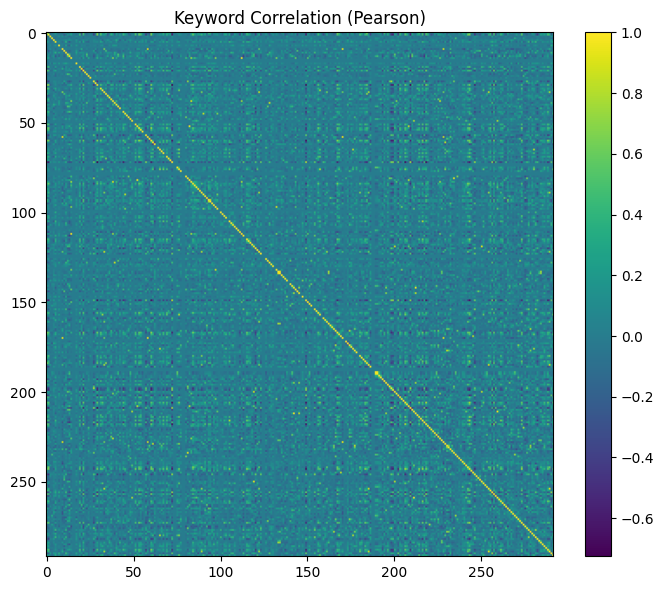

In [ ]:
pivot = df_trends.pivot_table(index='date', columns='keyword', values='value')
corr = pivot.corr(method='pearson').fillna(0)
plt.figure(figsize=(7,6))
plt.imshow(corr, aspect='auto')
plt.title("Keyword Correlation (Pearson)")
plt.colorbar()
plt.tight_layout()
plt.show()

## 14) Download outputs

In [ ]:
if IN_COLAB:
    for p in ["movies_clean.csv","momentum_top.csv","features.csv", FINAL_FILE]:
        path = os.path.join(OUTPUT_DIR, p)
        if os.path.exists(path):
            files.download(path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>